Python ETL & Analysis (The Core Processing)

In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

Load and Explore Data

In [25]:
# Load datasets
education_df = pd.read_csv('../data/raw/nep_edu_enroll.csv.txt')
unemployment_df = pd.read_csv('../data/raw/nepal_unemployment.csv.txt')
jobs_df = pd.read_csv('../data/raw/nepal_digital_jobs.csv')

# Display basic info
print("=== EDUCATION DATA ===")
print(education_df.info())
print("\nFirst 5 rows:")
print(education_df.head())

print("\n=== UNEMPLOYMENT DATA ===")
print(unemployment_df.info())
print("\nFirst 5 rows:")
print(unemployment_df.head())

print("\n=== JOB MARKET DATA ===")
print(jobs_df.info())
print("\nFirst 5 rows:")
print(jobs_df.head())

=== EDUCATION DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   District                     15 non-null     object 
 1   Province                     15 non-null     object 
 2   Total_Secondary_Enrollment   15 non-null     int64  
 3   Female_Secondary_Enrollment  15 non-null     int64  
 4   Female_STEM_Enrollment_Pct   15 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 732.0+ bytes
None

First 5 rows:
    District    Province  Total_Secondary_Enrollment  \
0  Kathmandu  Province 3                      125000   
1   Lalitpur  Province 3                       85000   
2  Bhaktapur  Province 3                       42000   
3      Kaski  Province 4                       78000   
4  Rupandehi  Province 5                       92000   

   Female_Secondary_Enrollment  Female_STEM_E

Data Cleaning and Integration

In [26]:
# Check for missing values
print("Missing values in Education data:")
print(education_df.isnull().sum())

print("\nMissing values in Unemployment data:")
print(unemployment_df.isnull().sum())

print("\nMissing values in Jobs data:")
print(jobs_df.isnull().sum())

# Merge all datasets
merged_df = education_df.merge(unemployment_df, on='District').merge(jobs_df, on='District')

# Create new features
merged_df['Female_Enrollment_Ratio'] = (merged_df['Female_Secondary_Enrollment'] / 
                                       merged_df['Total_Secondary_Enrollment']) * 100

merged_df['Digital_Jobs_Per_1000'] = (merged_df['Digital_Job_Postings'] / 
                                     (merged_df['Total_Secondary_Enrollment'] / 1000))

print("\n=== MERGED DATASET ===")
print(f"Shape: {merged_df.shape}")
print(merged_df.head())

Missing values in Education data:
District                       0
Province                       0
Total_Secondary_Enrollment     0
Female_Secondary_Enrollment    0
Female_STEM_Enrollment_Pct     0
dtype: int64

Missing values in Unemployment data:
District                    0
Youth_Unemployment_Rate     0
Female_Unemployment_Rate    0
Digital_Job_Growth_Pct      0
dtype: int64

Missing values in Jobs data:
District                0
Digital_Job_Postings    0
Avg_Salary_NPR          0
Top_Skills_In_Demand    0
dtype: int64

=== MERGED DATASET ===
Shape: (15, 13)
    District    Province  Total_Secondary_Enrollment  \
0  Kathmandu  Province 3                      125000   
1   Lalitpur  Province 3                       85000   
2  Bhaktapur  Province 3                       42000   
3      Kaski  Province 4                       78000   
4  Rupandehi  Province 5                       92000   

   Female_Secondary_Enrollment  Female_STEM_Enrollment_Pct  \
0                        62500 

Calculate Priority Score

In [27]:
# Normalize key metrics for scoring
scaler = MinMaxScaler()

metrics_to_scale = [
    'Female_STEM_Enrollment_Pct',  # invert this (low enrollment = high priority)
    'Youth_Unemployment_Rate',     # High unemployment = high priority
    'Digital_Job_Postings',        # High job opportunities = high priority
    'Digital_Jobs_Per_1000'        # High job density = high priority
]

scaled_features = scaler.fit_transform(merged_df[metrics_to_scale])
scaled_df = pd.DataFrame(scaled_features, columns=[f'scaled_{col}' for col in metrics_to_scale])

# Invert the enrollment score (lower enrollment = higher priority)
scaled_df['scaled_Female_STEM_Enrollment_Pct'] = 1 - scaled_df['scaled_Female_STEM_Enrollment_Pct']

# Create composite priority score
weights = {
    'education_gap': 0.35,       # STEM enrollment gap
    'unemployment_need': 0.30,   # Youth unemployment
    'opportunity': 0.25,         # Job availability
    'job_density': 0.10          # Job concentration
}

merged_df['EOF_Priority_Score'] = (
    weights['education_gap'] * scaled_df['scaled_Female_STEM_Enrollment_Pct'] +
    weights['unemployment_need'] * scaled_df['scaled_Youth_Unemployment_Rate'] +
    weights['opportunity'] * scaled_df['scaled_Digital_Job_Postings'] +
    weights['job_density'] * scaled_df['scaled_Digital_Jobs_Per_1000']
)

# Scale final score to 0-100 for readability
merged_df['EOF_Priority_Score'] = merged_df['EOF_Priority_Score'] * 100

print("=== PRIORITY SCORES ===")
print(merged_df[['District', 'EOF_Priority_Score']].sort_values('EOF_Priority_Score', ascending=False))

=== PRIORITY SCORES ===
       District  EOF_Priority_Score
14        Dolpa           65.073725
13   Dadeldhura           57.586085
5         Banke           54.229222
4     Rupandehi           48.700326
7   Nawalparasi           46.514822
11      Kailali           45.895449
12   Kanchanpur           43.997323
6          Dang           41.731257
8       Sunsari           38.084562
0     Kathmandu           36.516078
3         Kaski           36.338006
9        Morang           35.945643
10        Jhapa           34.471475
1      Lalitpur           32.657609
2     Bhaktapur           24.135006


AI-Powered Impact PredictionCalculate Priority Score

In [28]:
# Prepare data for prediction
X = merged_df[['Female_STEM_Enrollment_Pct', 'Digital_Job_Postings']]
y = merged_df['Youth_Unemployment_Rate']

# Train simple linear model
model = LinearRegression()
model.fit(X, y)

# Predict current unemployment
y_pred = model.predict(X)

# Create intervention scenario: 15% increase in STEM enrollment
X_intervention = X.copy()
X_intervention['Female_STEM_Enrollment_Pct'] = X_intervention['Female_STEM_Enrollment_Pct'] + 15
X_intervention['Female_STEM_Enrollment_Pct'] = X_intervention['Female_STEM_Enrollment_Pct'].clip(upper=100)

# Predict with intervention
y_pred_intervention = model.predict(X_intervention)

# Calculate potential impact
merged_df['Current_Predicted_Unemployment'] = y_pred
merged_df['Intervention_Predicted_Unemployment'] = y_pred_intervention
merged_df['Potential_Unemployment_Reduction'] = merged_df['Youth_Unemployment_Rate'] - merged_df['Intervention_Predicted_Unemployment']

print("=== PREDICTED IMPACT ANALYSIS ===")
print(f"Model R-squared: {model.score(X, y):.3f}")
print("\nTop 5 districts by potential impact:")
impact_df = merged_df[['District', 'Youth_Unemployment_Rate', 
                       'Intervention_Predicted_Unemployment', 'Potential_Unemployment_Reduction']]
print(impact_df.sort_values('Potential_Unemployment_Reduction', ascending=False).head())

=== PREDICTED IMPACT ANALYSIS ===
Model R-squared: 0.978

Top 5 districts by potential impact:
      District  Youth_Unemployment_Rate  Intervention_Predicted_Unemployment  \
1     Lalitpur                     12.8                            -1.159784   
14       Dolpa                     35.2                            21.423888   
11     Kailali                     26.3                            12.681214   
13  Dadeldhura                     31.5                            18.515243   
12  Kanchanpur                     25.1                            12.208172   

    Potential_Unemployment_Reduction  
1                          13.959784  
14                         13.776112  
11                         13.618786  
13                         12.984757  
12                         12.891828  


Visualization for Analysis

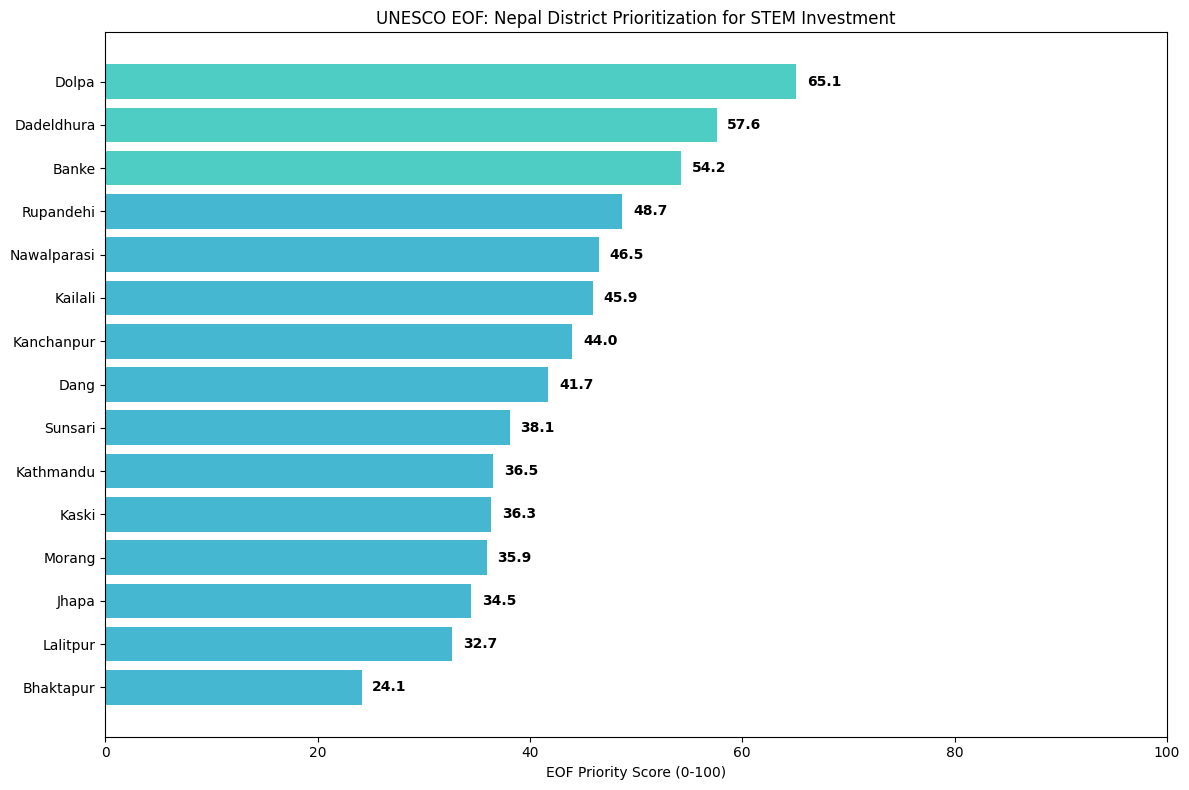

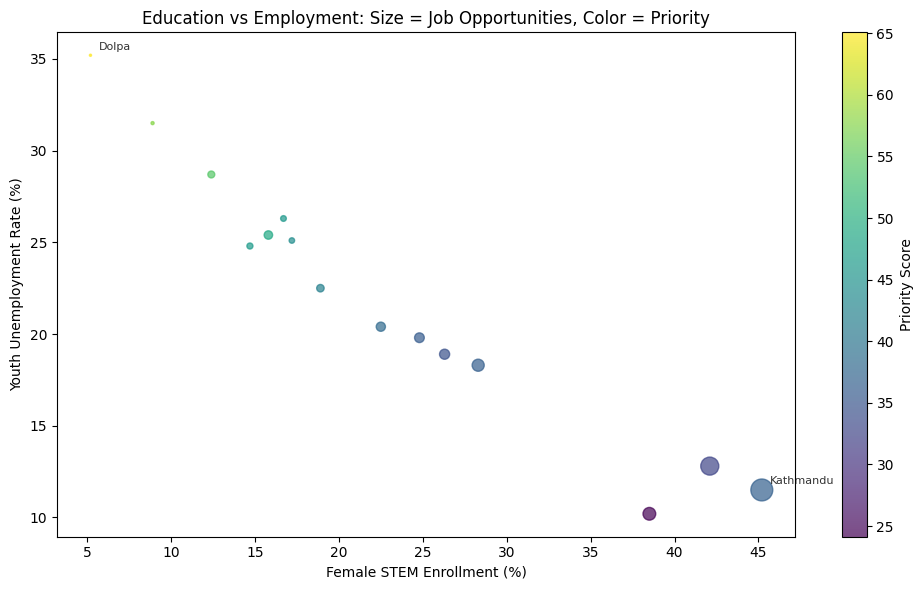

In [29]:
# Plot 1: Priority Scores
plt.figure(figsize=(12, 8))
priority_sorted = merged_df.sort_values('EOF_Priority_Score', ascending=False)
bars = plt.barh(priority_sorted['District'], priority_sorted['EOF_Priority_Score'], 
                color=['#FF6B6B' if x > 70 else '#4ECDC4' if x > 50 else '#45B7D1' for x in priority_sorted['EOF_Priority_Score']])
plt.xlabel('EOF Priority Score (0-100)')
plt.title('UNESCO EOF: Nepal District Prioritization for STEM Investment')
plt.xlim(0, 100)
plt.gca().invert_yaxis()

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}', 
             ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 2: Correlation Analysis
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Female_STEM_Enrollment_Pct'], merged_df['Youth_Unemployment_Rate'],
            s=merged_df['Digital_Job_Postings']/5, alpha=0.7, c=merged_df['EOF_Priority_Score'], cmap='viridis')
plt.colorbar(label='Priority Score')
plt.xlabel('Female STEM Enrollment (%)')
plt.ylabel('Youth Unemployment Rate (%)')
plt.title('Education vs Employment: Size = Job Opportunities, Color = Priority')

# Label some key districts
for i, row in merged_df.iterrows():
    if row['EOF_Priority_Score'] > 70 or row['District'] in ['Kathmandu', 'Dolpa']:
        plt.annotate(row['District'], (row['Female_STEM_Enrollment_Pct']+0.5, row['Youth_Unemployment_Rate']+0.3),
                    fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

Export for Power BI

In [30]:
# Select final columns for dashboard
final_columns = [
    'District', 'Province', 'Total_Secondary_Enrollment', 'Female_Secondary_Enrollment',
    'Female_STEM_Enrollment_Pct', 'Youth_Unemployment_Rate', 'Female_Unemployment_Rate',
    'Digital_Job_Postings', 'Avg_Salary_NPR', 'Digital_Jobs_Per_1000',
    'EOF_Priority_Score', 'Potential_Unemployment_Reduction'
]

final_df = merged_df[final_columns].copy()

# Add priority categories
final_df['Priority_Category'] = pd.cut(final_df['EOF_Priority_Score'],
                                      bins=[0, 40, 60, 80, 100],
                                      labels=['Low', 'Medium', 'High', 'Critical'])

# Save final dataset
final_df.to_csv('../data/processed/final_data.csv', index=False)
print("Final dataset saved for Power BI visualization!")

Final dataset saved for Power BI visualization!
